In [156]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from tabulate import tabulate

warnings.filterwarnings('ignore')
np.random.seed(5)

In [127]:
##### Step 1: Data Acquisition (Don't change this code)
start_date = "2023-01-01"
end_date = "2025-01-01" # End date is exclusive in some cases, so set it to the start of the next year

data = yf.download("AAPL", start=start_date, end=end_date)


data['Daily_Return'] = data['Close'].pct_change() 
data.dropna(inplace=True)

# Now calculate quantiles
q = data['Daily_Return'].quantile([0.2, 0.4, 0.6, 0.8]).values

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Daily_Return
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,
2023-01-04,124.482033,126.747853,123.221057,125.004155,89113600,0.010314
2023-01-05,123.161964,125.871094,122.905834,125.240606,80962700,-0.010604
2023-01-06,127.693581,128.353621,123.033882,124.137239,87754700,0.036794
2023-01-09,128.215714,131.427273,127.959583,128.530965,70790800,0.004089
2023-01-10,128.787094,129.309216,126.215883,128.324078,63896200,0.004456


In [128]:
q = np.insert(q, 0, data['Daily_Return'].min())

q = np.append(q, data['Daily_Return'].max())
print(q)

[-0.04816707 -0.00814746 -0.0012121   0.0044564   0.01147799  0.07264903]


In [129]:
bins = q
labels = ["Very Bearish", "Bearish", "Neutral", "Bullish", "Very Bullish"]

binned_data = pd.cut(data['Daily_Return'], bins=bins, labels=labels, include_lowest=True)
data['State'] = binned_data

state_map = {
    "Very Bearish": 0,
    "Bearish": 1,
    "Neutral": 2,
    "Bullish": 3,
    "Very Bullish": 4
}

# Load your dataframe
# For example, if you already have it as 'data'
# data = pd.read_csv('your_file.csv')  

# Convert state names to numeric
data['State_Num'] = data['State'].map(state_map)
data.head()

Price,Close,High,Low,Open,Volume,Daily_Return,State,State_Num
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,
Date,,,,,,,,
2023-01-04,124.482033,126.747853,123.221057,125.004155,89113600,0.010314,Bullish,3
2023-01-05,123.161964,125.871094,122.905834,125.240606,80962700,-0.010604,Very Bearish,0
2023-01-06,127.693581,128.353621,123.033882,124.137239,87754700,0.036794,Very Bullish,4
2023-01-09,128.215714,131.427273,127.959583,128.530965,70790800,0.004089,Neutral,2
2023-01-10,128.787094,129.309216,126.215883,128.324078,63896200,0.004456,Neutral,2


In [130]:
data['Next State'] = data['State'].shift(-1)
data.dropna(inplace=True)
data.tail()

Price,Close,High,Low,Open,Volume,Daily_Return,State,State_Num,Next State
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,,
2024-12-23,254.120682,254.498961,252.308869,253.622933,40858800,0.003065,Neutral,2,Bullish
2024-12-24,257.037476,257.047410,254.140559,254.339671,23234700,0.011478,Bullish,3,Neutral
2024-12-26,257.853760,258.928914,256.470034,257.027510,27237100,0.003176,Neutral,2,Very Bearish
2024-12-27,254.439209,257.535222,251.920601,256.669114,42355300,-0.013242,Very Bearish,0,Very Bearish
2024-12-30,251.064484,252.358634,249.621015,251.094347,35557500,-0.013263,Very Bearish,0,Bearish


In [131]:
contingency_table = pd.crosstab(data['State'], data['Next State'])
contingency_table

Next State,Very Bearish,Bearish,Neutral,Bullish,Very Bullish
State,,,,,
Very Bearish,21,25,19,19,17
Bearish,23,15,20,18,23
Neutral,15,20,21,22,22
Bullish,24,25,17,16,18
Very Bullish,18,15,23,24,20


In [132]:
transition_matrix = contingency_table.values.tolist()

print(transition_matrix)

[[21, 25, 19, 19, 17], [23, 15, 20, 18, 23], [15, 20, 21, 22, 22], [24, 25, 17, 16, 18], [18, 15, 23, 24, 20]]


In [133]:
for i in range(len(transition_matrix)):
    row_sum = sum(transition_matrix[i])
    for j in range(len(transition_matrix[i])):
        transition_matrix[i][j] /= row_sum 

# Verify that each row sums to 1
for row in transition_matrix:
    print(sum(row))

1.0
1.0
1.0
1.0
1.0


In [134]:
transition_probability_matrix = pd.DataFrame(transition_matrix, columns=labels, index=labels)
transition_probability_matrix

,Very Bearish,Bearish,Neutral,Bullish,Very Bullish
Very Bearish,0.207921,0.247525,0.188119,0.188119,0.168317
Bearish,0.232323,0.151515,0.202020,0.181818,0.232323
Neutral,0.150000,0.200000,0.210000,0.220000,0.220000
Bullish,0.240000,0.250000,0.170000,0.160000,0.180000
Very Bullish,0.180000,0.150000,0.230000,0.240000,0.200000


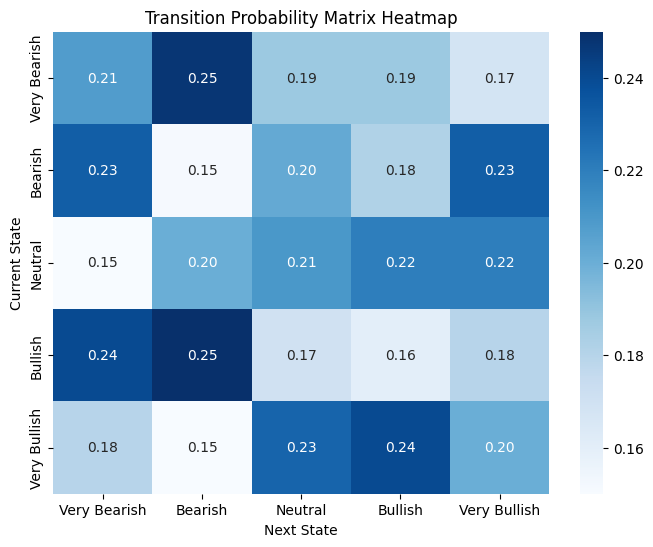

In [135]:
plt.figure(figsize=(8, 6))
sns.heatmap(transition_probability_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Transition Probability Matrix Heatmap")
plt.ylabel("Current State")
plt.xlabel("Next State")
plt.show()

In [136]:
P = np.array(transition_matrix)
n = P.shape[0]

A = P.T - np.eye(n) #A = (P'−I)

A[-1, :] = 1.0
b = np.zeros(n)
b[-1] = 1.0

pi = np.linalg.solve(A, b)   # solves A pi = b

pi = np.clip(pi, 0, None)
pi = pi / pi.sum()

print("Stationary distribution:")
print(pi)

Stationary distribution:
[0.201975   0.19980867 0.20006608 0.19805069 0.20009956]


In [137]:
mean_return_times = 1 / pi

for i, mrt in enumerate(mean_return_times):
    print(f"State {i}: Mean return time = {mrt:.4f}")

State 0: Mean return time = 4.9511
State 1: Mean return time = 5.0048
State 2: Mean return time = 4.9983
State 3: Mean return time = 5.0492
State 4: Mean return time = 4.9975


In [138]:
returns_by_state = {}
for state_num in range(5):
    returns_by_state[state_num] = data[data['State_Num'] == state_num]['Daily_Return'].values
    

In [152]:
def simulate_stock_path(initial_price, initial_state, transition_matrix, returns_by_state, days=100):
    price_path = [initial_price]
    state = initial_state
    
    for _ in range(days):
        # Sample return from current state
        ret = np.random.choice(returns_by_state[state])
        # Update price
        new_price = price_path[-1] * (1 + ret)
        price_path.append(new_price)
        
        # Move to next state
        probabilities = transition_matrix[state]
        state = np.random.choice(len(probabilities), p=probabilities)
    
    return list(map(float, price_path))


num_simulations = 1000
initial_price = data['Close'].iloc[-1]  
initial_state = state_map[data['State'].iloc[-1]] 

print(f"Initial price: {initial_price}, Initial state: {initial_state}")
sim_path100 = simulate_stock_path(initial_price, initial_state, transition_matrix, returns_by_state)
sim_path100 = np.array(sim_path100)
# Run simulations
all_simulations = []
for _ in range(num_simulations):
    path = simulate_stock_path(initial_price, initial_state, transition_matrix, returns_by_state)
    all_simulations.append(path)

all_simulations = np.array(all_simulations) 


expected_price_day100 = np.mean(all_simulations[:, -1])
print(f"Expected price at day 100: {expected_price_day100:.2f}")

simulations_df = pd.DataFrame(all_simulations).T
simulations_df.columns = [f'Sim {i+1}' for i in range(num_simulations)]

simulations_df


Initial price: Ticker
AAPL    251.064484
Name: 2024-12-30 00:00:00, dtype: float64, Initial state: 0
Expected price at day 100: 285.48


,Sim 1,Sim 2,Sim 3,Sim 4,Sim 5,Sim 6,Sim 7,Sim 8,Sim 9,Sim 10,...,Sim 991,Sim 992,Sim 993,Sim 994,Sim 995,Sim 996,Sim 997,Sim 998,Sim 999,Sim 1000
0,251.064484,251.064484,251.064484,251.064484,251.064484,251.064484,251.064484,251.064484,251.064484,251.064484,...,251.064484,251.064484,251.064484,251.064484,251.064484,251.064484,251.064484,251.064484,251.064484,251.064484
1,243.748040,244.091129,248.044554,247.972098,244.713559,248.858934,243.720953,248.088172,244.234203,245.234561,...,246.232531,248.020927,246.492733,245.663337,248.446058,247.175504,248.529399,243.748040,248.252479,247.875942
2,243.649743,244.587538,246.633921,248.670403,247.263732,249.727788,244.577519,239.208250,248.916746,242.572354,...,246.987238,246.377704,246.663774,244.652715,248.718048,246.652971,246.922107,244.368011,249.156896,249.496796
3,242.936467,245.332631,247.817164,244.427934,245.037874,252.044892,239.338230,241.953879,247.453556,243.315335,...,245.114823,247.091216,246.460682,242.843564,248.647940,248.224797,244.343161,246.477304,247.742850,242.400873
4,246.314083,239.805088,249.145560,248.507813,243.647204,250.663509,238.471484,238.021118,248.695434,248.452257,...,240.933015,250.917110,245.788897,245.234763,246.409622,247.325869,245.352149,250.426480,249.272271,240.311695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,246.648930,269.807246,230.844559,298.035184,305.949146,299.556305,245.941876,260.094977,216.104131,326.588071,...,243.199930,316.386882,300.570634,249.661951,282.885573,376.890080,257.701055,235.543007,300.568447,210.427835
97,244.314518,268.062345,233.305261,295.803632,306.303098,295.578304,242.685065,261.158493,217.768529,335.861650,...,241.306700,312.368740,300.586457,250.444043,288.204818,378.214672,259.082432,235.639004,298.302639,209.876123
98,239.031722,269.660994,233.305261,294.711199,304.632487,302.090446,240.867949,260.053535,214.953353,342.468546,...,246.825874,318.613988,304.311300,251.819272,287.369755,382.105780,257.396996,233.860718,295.988939,211.713884
99,235.146458,270.764978,232.369007,298.744063,302.042040,302.439934,231.026735,260.582406,214.232789,346.520493,...,247.285968,318.814217,308.055931,257.311504,285.676800,385.126325,258.185923,229.587897,293.355330,210.211488


In [151]:
def backtest_model(historical_data, window_size, n_sims=100):
    predictions = []
    actuals = []
    lower_ci = []
    upper_ci = []

    for t in range(window_size, len(historical_data)):
        window_data = historical_data.iloc[t - window_size : t]
        window_states = window_data['State_Num'].values

        n_states = int(window_states.max() + 1)

        counts = np.zeros((n_states, n_states))
        for i in range(len(window_states) - 1):
            counts[window_states[i], window_states[i+1]] += 1

        row_sums = counts.sum(axis=1, keepdims=True)
        P = counts / np.where(row_sums == 0, 1, row_sums)

        returns_by_state = {}
        for s in range(n_states):
            s_returns = window_data['Daily_Return'].values[window_states == s]
            if len(s_returns) == 0:
                s_returns = window_data['Daily_Return'].values
            returns_by_state[s] = s_returns

        initial_price = historical_data['Close'].iloc[t-1]
        current_state = historical_data['State_Num'].iloc[t-1]

        simulated_prices = []
        for _ in range(n_sims):
            transition_probs = P[current_state]
            if np.isnan(transition_probs).any():
                next_state = current_state
            else:
                next_state = np.random.choice(n_states, p=transition_probs)

            ret = np.random.choice(returns_by_state[next_state])
            next_price = initial_price * (1 + ret)
            simulated_prices.append(next_price)

        predictions.append(np.mean(simulated_prices))
        lower_ci.append(np.percentile(simulated_prices, 2.5))
        upper_ci.append(np.percentile(simulated_prices, 97.5))
        actuals.append(historical_data['Close'].iloc[t])

    backtest_df = pd.DataFrame({
        'Actual': actuals,
        'Predicted': predictions,
        'Lower_CI': lower_ci,
        'Upper_CI': upper_ci
    }, index=historical_data.index[window_size:])

    return backtest_df

# Run backtest (e.g., on last 100 days with a 150-day window)
backtest_window = 150
backtest_data = data.iloc[-250:] # Use last ~year of data
backtest_results = backtest_model(backtest_data, backtest_window)

backtest_results.tail()

,Actual,Predicted,Lower_CI,Upper_CI
Date,,,,
2024-12-23,Ticker AAPL 254.120682 Name: 2024-12-23 00:...,253.837643,246.681638,259.138673
2024-12-24,Ticker AAPL 257.037476 Name: 2024-12-24 00:...,255.262145,249.604118,263.539822
2024-12-26,Ticker AAPL 257.85376 Name: 2024-12-26 00:0...,257.915574,250.464956,265.592743
2024-12-27,Ticker AAPL 254.439209 Name: 2024-12-27 00:...,258.770806,252.728667,263.428667
2024-12-30,Ticker AAPL 251.064484 Name: 2024-12-30 00:...,255.219698,244.483000,268.623409


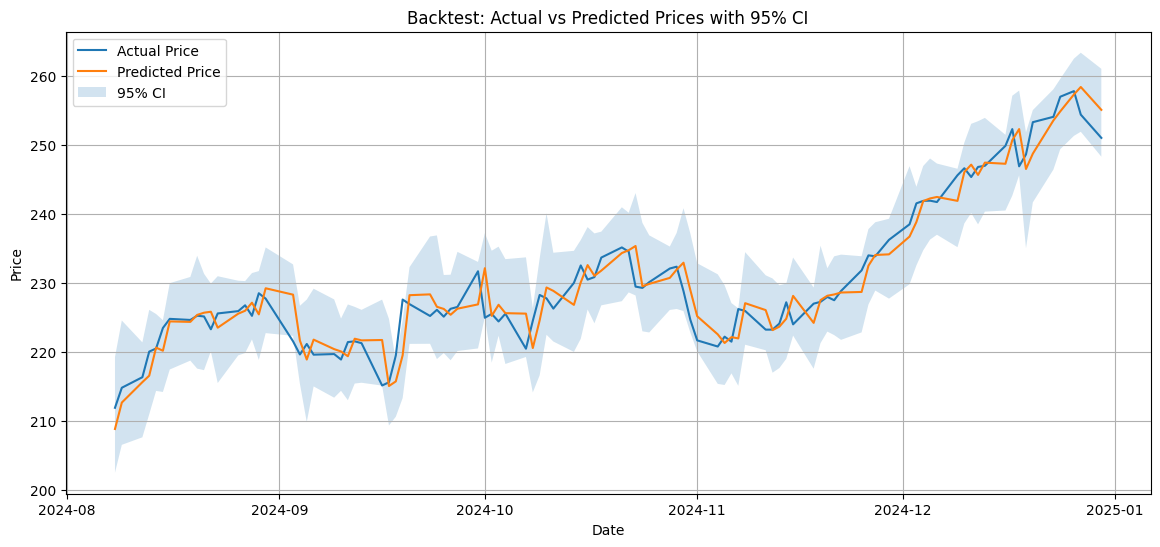

In [141]:
plt.figure(figsize=(14, 6))

# Actual prices
plt.plot(backtest_results.index, backtest_results["Actual"], label="Actual Price")

# Predicted mean
plt.plot(backtest_results.index, backtest_results["Predicted"], label="Predicted Price")

# Confidence interval shading
plt.fill_between(
    backtest_results.index,
    backtest_results["Lower_CI"],
    backtest_results["Upper_CI"],
    alpha=0.2,
    label="95% CI"
)

plt.title("Backtest: Actual vs Predicted Prices with 95% CI")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

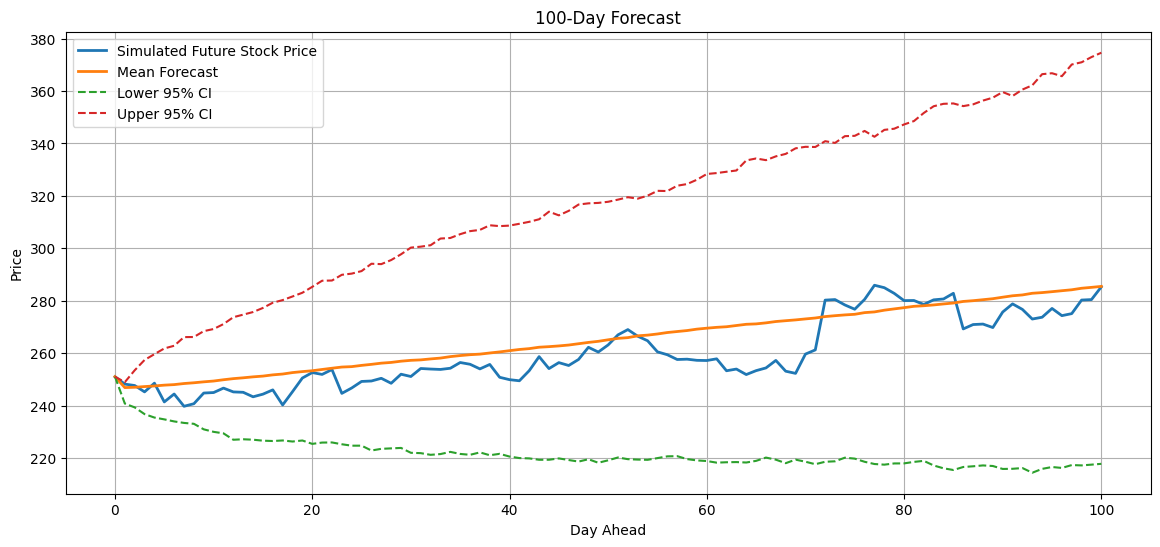

In [154]:
forecast_mean = all_simulations.mean(axis=0)
lower_ci = np.percentile(all_simulations, 2.5, axis=0)
upper_ci = np.percentile(all_simulations, 97.5, axis=0)

plt.figure(figsize=(14, 6))

days = all_simulations.shape[1] 


# for i in range(min(30, num_simulations)):  
#     plt.plot(range(days), all_simulations[i], alpha=0.25)

# Plot forecast mean
plt.plot(range(days), sim_path100, linewidth=2, label="Simulated Future Stock Price")
plt.plot(range(days), forecast_mean, linewidth=2, label="Mean Forecast")

plt.plot(range(days), lower_ci, linestyle="--", label="Lower 95% CI")
plt.plot(range(days), upper_ci, linestyle="--", label="Upper 95% CI")

plt.title("100-Day Forecast")
plt.xlabel("Day Ahead")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [162]:
##### Step 8: Generate Summary Statistics
final_day_prices = simulations_df.iloc[-1]

## __code below__
#statistics to inclide
#Current Price
current_price = sim_path100[0]

#Predicted Price (100 Days, Mean)
predicted_price_100 = expected_price_day100
#Average Predicted Price (Period)
average_predicted_price = np.mean(sim_path100)
#Prediction Range (Min)
prediction_min = min(sim_path100)
#Prediction Range (Max)
prediction_max = max(sim_path100)

#Historical Volatility (2y, Ann.)
historical_volatility = np.std(data['Daily_Return'])
annualized_historical_volatility = historical_volatility * np.sqrt(252)
#Simulated Volatility (100d, Ann.)
sim_returns = np.diff(sim_path100) / sim_path100[:-1]
simulated_volatility = np.std(sim_returns)
annualized_simulated_volatility = simulated_volatility * np.sqrt(252)

#90% CI (Final Price)
final_prices = simulations_df.iloc[100].values
ci_90 = (
    np.percentile(final_prices, 5),
    np.percentile(final_prices, 95)
)
#95% CI (Final Price)
ci_95 = (
    np.percentile(final_prices, 2.5),
    np.percentile(final_prices, 97.5)
)

table = [
    ["Current price", round(current_price, 2)],
    ["Predicted price after 100 days", round(predicted_price_100, 2)],
    ["Average predicted price", round(average_predicted_price, 2)],
    ["Min predicted price", round(prediction_min, 2)],
    ["Max predicted price", round(prediction_max, 2)],
    ["Historical volatility (daily)", round(historical_volatility, 4)],
    ["Historical volatility (annualized)", round(annualized_historical_volatility, 4)],
    ["Simulated volatility (daily)", round(simulated_volatility, 4)],
    ["Simulated volatility (annualized)", round(annualized_simulated_volatility, 4)],
    ["90% CI (final price)", (round(float(ci_90[0]), 2), round(float(ci_90[1]), 2))],
    ["95% CI (final price)", (round(float(ci_95[0]), 2), round(float(ci_95[1]), 2))],
]

print(tabulate(table, headers=["Metric", "Value"], tablefmt="github"))


| Metric                             | Value            |
|------------------------------------|------------------|
| Current price                      | 251.06           |
| Predicted price after 100 days     | 285.48           |
| Average predicted price            | 259.95           |
| Min predicted price                | 239.77           |
| Max predicted price                | 285.93           |
| Historical volatility (daily)      | 0.0134           |
| Historical volatility (annualized) | 0.2135           |
| Simulated volatility (daily)       | 0.0143           |
| Simulated volatility (annualized)  | 0.2274           |
| 90% CI (final price)               | (226.24, 354.83) |
| 95% CI (final price)               | (217.83, 374.59) |


In [188]:
simulated_last_month = simulations_df.tail(22) #in a month there are normally 22 trading days because weekends are not trading days
daily_avg_last_month = simulated_last_month.mean(axis=1).values
daily_avg_last_month.shape


(22,)

In [190]:
start_date = "2024-12-31"
end_date = "2025-05-28"  # 100 trading days into the future

data_future = yf.download("AAPL", start=start_date, end=end_date)
data_future.tail()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-05-20,206.425400,208.032018,204.599243,207.233696,42496600
2025-05-21,201.665421,206.605018,200.288330,204.738952,59211800
2025-05-22,200.936951,202.324030,199.280435,200.288322,46742400
2025-05-23,194.859741,197.284628,193.053546,193.263097,78432900
2025-05-27,199.789368,200.318253,197.015194,197.883377,56288500


In [187]:
last_month_actual_close = data_future['Close'].tail(22).values.flatten()
last_month_actual_close.shape

(22,)

In [189]:
comparison_df = pd.DataFrame({
    "Actual_Close": last_month_actual_close,
    "Simulated_Avg": daily_avg_last_month
})
comparison_df

,Actual_Close,Simulated_Avg
0,208.566803,276.908206
1,209.423874,277.381970
2,210.490234,277.890218
3,211.775833,278.112718
4,212.593048,278.420259
5,204.650208,278.797500
6,198.212219,279.146560
7,197.833496,279.751994
8,195.581207,280.037308
9,196.816986,280.415760


In [2]:
##### Step 9: Evaluate Model Performance
#__ code below___


print(f"""
Discussion:
The backtest graph shows that the Markov chain model is highly reliable and provides meaningful practical insights. 
The predicted prices track the actual price movements very closely, both in direction and magnitude, which indicates that the transition probabilities and return distributions assigned to each state are well specified. 
The model captures not only the overall upward trend but also the short term fluctuations, demonstrating strong regime awareness and good responsiveness to market changes

However, the backtest results may have initially suggested that the Markov chain model was reliable, 
but the forward looking predictions reveal a serious limitation. 
While the model fit past data extremely well, its simulated future averages diverge dramatically from the actual future prices, 
with simulated values in the 270–285 range while actual prices remain around 195–215.
""")


Discussion:
The backtest graph shows that the Markov chain model is highly reliable and provides meaningful practical insights. 
The predicted prices track the actual price movements very closely, both in direction and magnitude, which indicates that the transition probabilities and return distributions assigned to each state are well specified. 
The model captures not only the overall upward trend but also the short term fluctuations, demonstrating strong regime awareness and good responsiveness to market changes

However, the backtest results may have initially suggested that the Markov chain model was reliable, 
but the forward looking predictions reveal a serious limitation. 
While the model fit past data extremely well, its simulated future averages diverge dramatically from the actual future prices, 
with simulated values in the 270–285 range while actual prices remain around 195–215.

